In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re


In [ ]:
train=pd.read_csv('./data/train.tsv',sep="\t")

In [ ]:
#가설: 판매자가 적극적일수록(판매자의 신뢰도가 높을수록) 상품의 가격은 높을 것이다

#판매자가 적극적이다 = 판매자의 신뢰도가 높다

#다음 기준을 만족하기 위해서 새로 세운 기준
# 1) item_description의 글자 수를 계산하여 설명의 길이 구하기 > 정량화
# 2) item_description에 'authentic(정품)', 'new', 'NWT(New with tags)', 'mint condition(최상급 상태)' 등 긍정적/신뢰도 키워드가 몇 개나 포함되었는지 계산
# 3) 신뢰도 점수 새롭게 생성
    #중요도
    #가중치 > 정규화 스케일링 필요
    #corr

In [ ]:
#가격 = 0이면 삭제
zero_price_count = (train['price'] == 0).sum()
train = train[train['price'] > 0].copy()

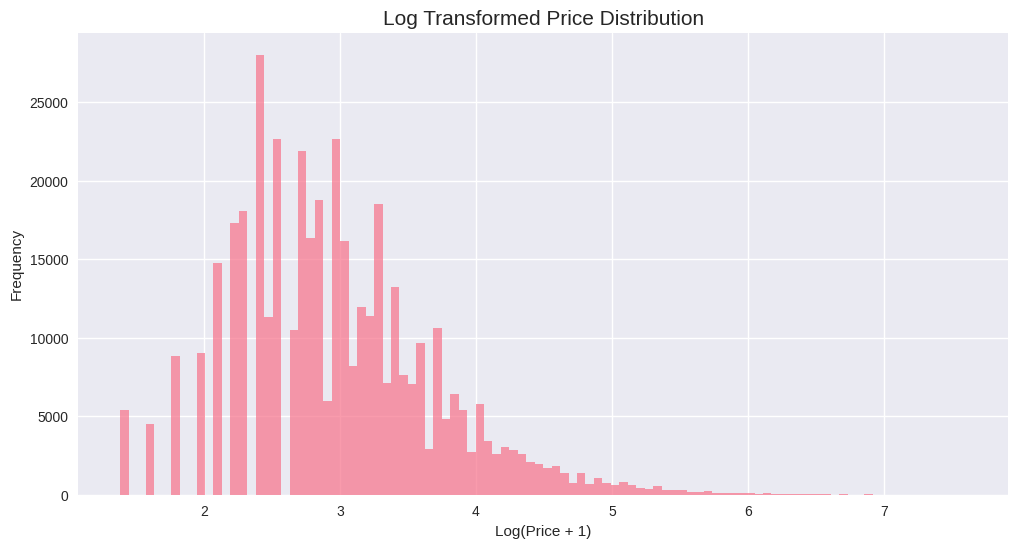

In [ ]:
#가격 로그변환 후 히스토그램 출력
plt.figure(figsize=(12, 6))
plt.hist(np.log1p(train['price']), bins=100, alpha=0.7)
plt.title('Log Transformed Price Distribution', fontsize=15)
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
#결측치 사전 제거 > 카테고리 네임, 아이템 설명
columns_to_check = ['category_name', 'item_description']
train.dropna(subset=columns_to_check, inplace=True)

train.isna().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,177969
price,0
shipping,0
item_description,0


In [ ]:
#brand_name 결측치 처리
train['is_brand'] = np.where(train['brand_name'].isna(), 0, 1) #0 > 아니다, 1 > 브랜드 O

print(train[['brand_name', 'is_brand']].head())

  brand_name  is_brand
0        NaN         0
1      Razer         1
2     Target         1
3        NaN         0
4        NaN         0


In [ ]:
#상품 설명 결측치 처리, 글자수 세기 (뛰어쓰기 포함)
count = (train['item_description'] == 'No description yet').sum()

print(count)

23217


In [ ]:
train['new_item_desc'] = train['item_description']

train['new_item_desc'] = train['new_item_desc'].replace('No description yet', np.nan)
train['new_item_desc'] = train['new_item_desc'].fillna('')

train['desc_len'] = train['new_item_desc'].str.len()

print(train[['item_description', 'new_item_desc', 'desc_len']].head(10))

                                    item_description  \
0                                 No description yet   
1  This keyboard is in great condition and works ...   
2  Adorable top with a hint of lace and a key hol...   
3  New with tags. Leather horses. Retail for [rm]...   
4          Complete with certificate of authenticity   
5  Banana republic bottoms, Candies skirt with ma...   
6  Size small but straps slightly shortened to fi...   
7  You get three pairs of Sophie cheer shorts siz...   
8   Girls Size small Plus green. Three shorts total.   
9  I realized his pants are on backwards after th...   

                                       new_item_desc  desc_len  
0                                                            0  
1  This keyboard is in great condition and works ...       188  
2  Adorable top with a hint of lace and a key hol...       124  
3  New with tags. Leather horses. Retail for [rm]...       173  
4          Complete with certificate of authenticity      

In [ ]:
#카테고리 분류

split_categories = train['category_name'].str.split('/', n=2, expand=True)

train['main_category'] = split_categories[0]
train['mid_category'] = split_categories[1]
train['sub_category'] = split_categories[2]

print(train[['category_name', 'main_category', 'mid_category', 'sub_category']].head(10))

                                       category_name           main_category  \
0                                  Men/Tops/T-shirts                     Men   
1  Electronics/Computers & Tablets/Components & P...             Electronics   
2                        Women/Tops & Blouses/Blouse                   Women   
3                 Home/Home Décor/Home Décor Accents                    Home   
4                            Women/Jewelry/Necklaces                   Women   
5                                  Women/Other/Other                   Women   
6                           Women/Swimwear/Two-Piece                   Women   
7                    Sports & Outdoors/Apparel/Girls       Sports & Outdoors   
8                    Sports & Outdoors/Apparel/Girls       Sports & Outdoors   
9           Vintage & Collectibles/Collectibles/Doll  Vintage & Collectibles   

          mid_category        sub_category  
0                 Tops            T-shirts  
1  Computers & Tablets  Compo

In [ ]:
train['main_category'].unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'Handmade'],
      dtype=object)

In [ ]:
train['mid_category'].unique()

array(['Tops', 'Computers & Tablets', 'Tops & Blouses', 'Home Décor',
       'Jewelry', 'Other', 'Swimwear', 'Apparel', 'Collectibles',
       'Makeup', 'Fragrance', 'Dresses', 'Office supplies', 'Shoes',
       'Gear', 'Athletic Apparel', 'Cell Phones & Accessories', 'Jeans',
       'Underwear', 'Skin Care', 'Toys', "Women's Handbags",
       'Video Games & Consoles', 'Coats & Jackets', 'Pants', 'Girls (4+)',
       'Antique', 'Kitchen & Dining', 'Sweaters', 'Boys 0-24 Mos',
       'Girls 0-24 Mos', 'Maternity', 'Bedding', 'Exercise',
       'Trading Cards', 'Boys (4+)', 'Storage & Organization', 'Fan Shop',
       'Girls 2T-5T', "Men's Accessories", 'Boys 2T-5T',
       "Women's Accessories", 'Daily & Travel items', 'Skirts',
       'Hair Care', 'Pet Supplies', 'Book', 'Tools & Accessories',
       'Team Sports', 'Home Appliances', 'Accessories', 'Bags and Purses',
       'Sweats & Hoodies', 'Shorts', 'TV, Audio & Surveillance',
       'Outdoors', 'Bath & Body', 'Car Seats & Accessor

In [ ]:
train['main_category'].value_counts()

,count
main_category,
Women,188180
Beauty,58895
Kids,48629
Electronics,34661
Men,26528
Home,19153
Vintage & Collectibles,13229
Other,12861
Handmade,8639


In [ ]:
# 키워드 리스트 > 신뢰도
# 대소문자 구분 X
keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
keyword_pattern = '|'.join(keyword_list)

train['keyword_count'] = train['item_description'].str.lower().str.count(keyword_pattern)

print(train[['item_description', 'keyword_count']].sort_values(by='keyword_count', ascending=False).head())

#상품을 강조하고 검색에 잘 노출시키기 위해, 신뢰도를 주는 키워드들을 설명에 의도적으로 반복해서 많이 사용하는 '키워드 스터핑(Keyword Stuffing)' 전략
#키워드를 많이 사용한 상품들이 실제로도 평균보다 높은 가격에 팔리는가

                                         item_description  keyword_count
196308  Welcome! This is a bundle of crafts supplies d...             19
276784  Bin Pickers from YT wholesale lot #60. All kid...             19
391340  FREE SHIP BUNDLE INCLUDES EVERYTHING IN PICS- ...             18
31019   Lot #13. 25 piece lot. Most items are gently u...             14
149094  (left to right) WILL NOT SEPARATE SO DO NOT AS...             14


In [ ]:
#상관분석

numeric_features = [
    'price',
    'item_condition_id',
    'shipping',
    'is_brand', # has_brand와 동일
    'desc_len',
    'keyword_count'
]

corr_df = train[numeric_features]

corr_matrix = corr_df.corr()
print(corr_matrix)


                      price  item_condition_id  shipping  is_brand  desc_len  \
price              1.000000          -0.001825 -0.097033  0.126202  0.048231   
item_condition_id -0.001825           1.000000 -0.192732  0.162794 -0.132403   
shipping          -0.097033          -0.192732  1.000000 -0.136337  0.111110   
is_brand           0.126202           0.162794 -0.136337  1.000000 -0.117785   
desc_len           0.048231          -0.132403  0.111110 -0.117785  1.000000   
keyword_count      0.105926          -0.354049  0.077279  0.003651  0.306718   

                   keyword_count  
price                   0.105926  
item_condition_id      -0.354049  
shipping                0.077279  
is_brand                0.003651  
desc_len                0.306718  
keyword_count           1.000000  


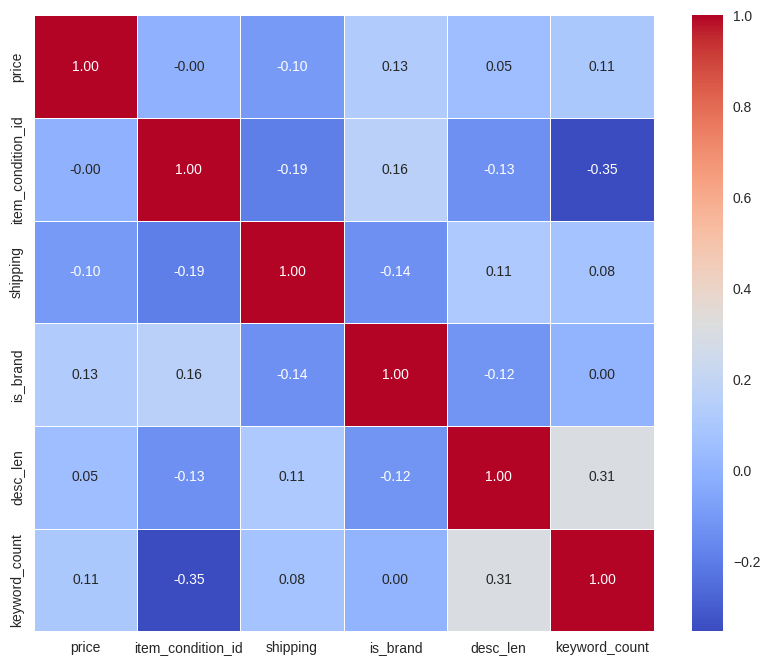

In [ ]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5)
plt.show()

In [ ]:
#정규화
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
scaler = MinMaxScaler()

for feature in features_to_normalize:
    train[f'{feature}_norm'] = scaler.fit_transform(train[[feature]])

#원핫인코딩 > 카테고리 대분류
main_category_dummies = pd.get_dummies(train['main_category'], prefix='category')
train_processed = pd.concat([train, main_category_dummies], axis=1)

#병합
final_features_list = [
    'item_condition_id_norm',
    'desc_len_norm',
    'keyword_count_norm',
    'shipping',
    'is_brand'
] + list(main_category_dummies.columns)

final_df = train_processed[final_features_list]
print(final_df.head())

   item_condition_id_norm  desc_len_norm  keyword_count_norm  shipping  \
0                     0.5       0.000000            0.000000       1.0   
1                     0.5       0.184676            0.052632       0.0   
2                     0.0       0.121807            0.000000       1.0   
3                     0.0       0.169941            0.052632       1.0   
4                     0.0       0.040275            0.052632       0.0   

   is_brand  category_Beauty  category_Electronics  category_Handmade  \
0         0            False                 False              False   
1         1            False                  True              False   
2         1            False                 False              False   
3         0            False                 False              False   
4         0            False                 False              False   

   category_Home  category_Kids  category_Men  category_Other  \
0          False          False          True      

In [ ]:
#상관관게 기반 가중치, 최종 신뢰도 점수 계산
score_features = [
    'item_condition_id_norm',
    'keyword_count_norm',
    'desc_len_norm',
    'shipping',
    'is_brand'
]


correlations = train_processed[score_features].corrwith(np.log1p(train_processed['price']))

abs_correlations = correlations.abs()

weights = abs_correlations / abs_correlations.sum()
print(weights)


#신뢰도 점수 계산
train_processed['credibility_score'] = (
    (1 - train_processed['item_condition_id_norm']) * weights.get('item_condition_id_norm', 0) +
    train_processed['keyword_count_norm'] * weights.get('keyword_count_norm', 0) +
    train_processed['desc_len_norm'] * weights.get('desc_len_norm', 0) +
    train_processed['shipping'] * weights.get('shipping', 0) +
    train_processed['is_brand'] * weights.get('is_brand', 0)
)

print(train_processed[['price', 'credibility_score']].head())

final_df['credibility_score'] = train_processed['credibility_score']
print(final_df.head())

item_condition_id_norm    0.006159
keyword_count_norm        0.231471
desc_len_norm             0.049912
shipping                  0.375517
is_brand                  0.336941
dtype: float64
   price  credibility_score
0   10.0           0.378596
1   52.0           0.361421
2   10.0           0.724697
3   35.0           0.402340
4   44.0           0.020352
   item_condition_id_norm  desc_len_norm  keyword_count_norm  shipping  \
0                     0.5       0.000000            0.000000       1.0   
1                     0.5       0.184676            0.052632       0.0   
2                     0.0       0.121807            0.000000       1.0   
3                     0.0       0.169941            0.052632       1.0   
4                     0.0       0.040275            0.052632       0.0   

   is_brand  category_Beauty  category_Electronics  category_Handmade  \
0         0            False                 False              False   
1         1            False                  True 

In [ ]:
#다중공선성 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

features_for_vif = train[[
    'item_condition_id_norm',
    'keyword_count_norm',
    'desc_len_norm',
    'shipping',
    'is_brand'
]].copy()


features_for_vif.dropna(inplace=True)

features_for_vif['intercept'] = 1

vif = pd.DataFrame()
vif["Variable"] = [col for col in features_for_vif.columns if col != 'intercept'] # intercept 제외
vif["VIF"] = [variance_inflation_factor(features_for_vif.drop('intercept', axis=1).values, i) for i in range(features_for_vif.shape[1] - 1)]
print(vif)

                 Variable       VIF
0  item_condition_id_norm  1.730245
1      keyword_count_norm  1.704829
2           desc_len_norm  1.747975
3                shipping  1.499515
4                is_brand  1.966149


MSE: 0.4595


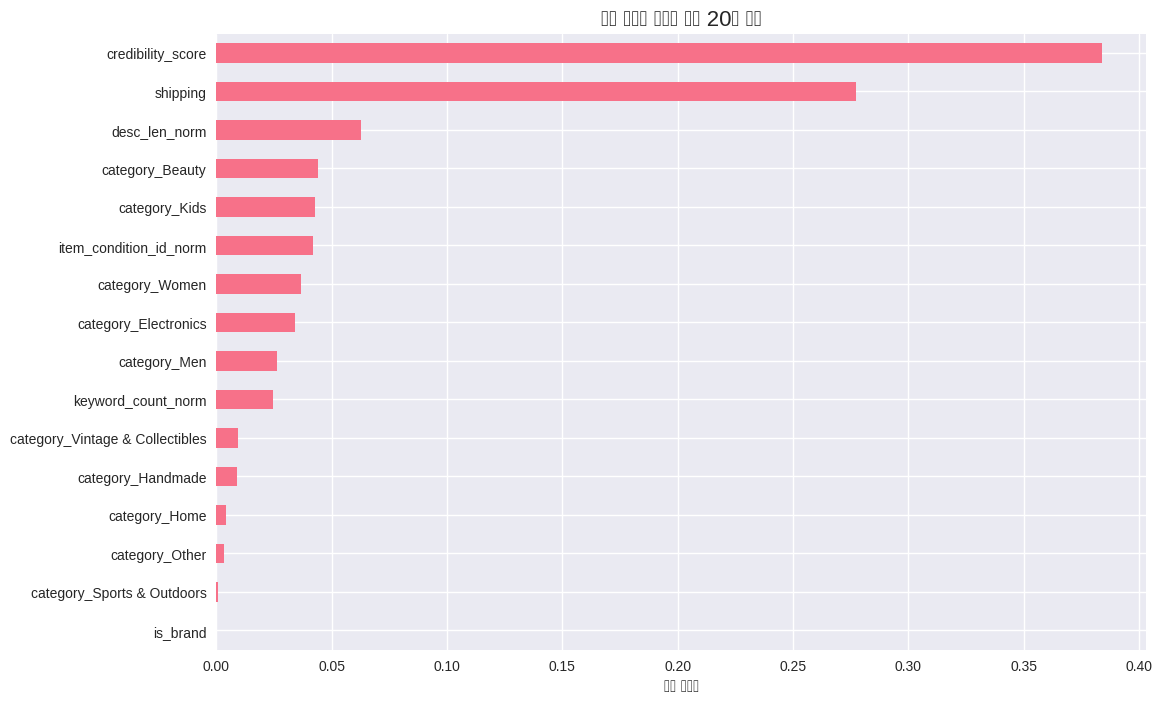

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = final_df
y = np.log1p(train_processed['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse:.4f}")

#변수 중요도 추출
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 상위 20개, 중요도 순으로 정렬
plt.figure(figsize=(12, 8))
feature_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh') # 보기 좋게 정렬
plt.title('가격 예측에 중요한 상위 20개 변수', fontsize=16)
plt.xlabel('피처 중요도', fontsize=12)
plt.show()